In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from preprocessing import preproc_img

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from kerastuner import RandomSearch
from VGG16_kt import build_model_VGG16
from sklearn.model_selection import train_test_split

2024-04-25 19:18:30.081889: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 19:18:30.346800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-25 19:18:31.298294: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/tmp/ipykernel_56250/1230767608.py:19: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


In [ ]:
df_images = pd.read_csv('df_images.csv')
df_masks = pd.read_csv('df_masks.csv')

In [ ]:
# importation et preprocessing des images
data, target = preproc_img(df_images, df_masks, n_img=1000, normalize=True, files_path='PATH_NOMASK', resolution=[224, 224, 3], with_masks=False)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

label_encoder = LabelEncoder()

# Encoder les labels textuels en entiers
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Appliquer l'encodage one-hot
y_train = to_categorical(y_train_encoded)
y_test = to_categorical(y_test_encoded)

In [4]:
#création d'un sous jeu de Validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2,random_state= 12)

In [2]:
#declaration du keras tuner
tuner = RandomSearch(
        build_model_VGG16,
        objective='val_accuracy',
        max_trials=20,
        executions_per_trial=1,
        overwrite = True,
        directory='my_dir',
        project_name="VGG16final", 
        )

2024-04-25 19:18:32.283820: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 19:18:32.376504: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 19:18:32.376539: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 19:18:32.378948: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-25 19:18:32.379052: I external/local_xla/xla/stream_executor

In [5]:
#lancement de la recherche d'hyperparametres
tuner.search(X_train, 
                y_train, 
                validation_data=(X_val, y_val), 
                epochs=20)

Trial 20 Complete [00h 02m 36s]
val_accuracy: 0.890625

Best val_accuracy So Far: 0.932812511920929
Total elapsed time: 00h 53m 04s


In [6]:
#récupération et affichage des 10 meilleurs trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)


results = []
   
for trial in best_trials:
    trial_data = trial.hyperparameters.values
    trial_data['score'] = trial.score
    results.append(trial_data)
   
df_results = pd.DataFrame(results)

df_results

,units,dropout,learning_rate,score
0,512,0.0,0.00010,0.932813
1,1024,0.0,0.00001,0.928125
2,2056,0.4,0.00010,0.928125
3,2056,0.0,0.00001,0.926562
4,256,0.2,0.00001,0.923437
5,128,0.4,0.00001,0.921875
6,128,0.0,0.00001,0.920313
7,128,0.0,0.00100,0.904688
8,128,0.3,0.00100,0.904688
9,256,0.3,0.00100,0.890625


In [7]:
# récuparétion de la meilleure combinaison d'hyper parametres
best_hyperparameters = tuner.get_best_hyperparameters()[0]
# déclaration du modèle avec les meilleurs hyper parametres
new_model = build_model_VGG16(best_hyperparameters)

In [8]:
#entrainement du modèle
history = new_model.fit(X_train, 
                        y_train, 
                        epochs=30, 
                        batch_size= 32,
                        validation_data=(X_val, y_val))

Epoch 1/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 10s 99ms/step - accuracy: 0.5649 - loss: 0.9949 - val_accuracy: 0.8219 - val_loss: 0.4802
Epoch 2/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.8511 - loss: 0.4031 - val_accuracy: 0.8703 - val_loss: 0.3866
Epoch 3/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9042 - loss: 0.2519 - val_accuracy: 0.9141 - val_loss: 0.2740
Epoch 4/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9429 - loss: 0.1595 - val_accuracy: 0.8969 - val_loss: 0.3030
Epoch 5/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9472 - loss: 0.1479 - val_accuracy: 0.8781 - val_loss: 0.3211
Epoch 6/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9533 - loss: 0.1174 - val_accuracy: 0.9125 - val_loss: 0.2653
Epoch 7/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9704 - loss: 0.0876 - val_accuracy: 0.8922 - val_loss: 0.3260
Epoch 8/30
80/80 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.9745 - loss: 0.0705 - val_accuracy: 0.8969 - 

In [9]:
# Prédiction sur l'ensemble de test
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
#print("Matrice de confusion :")
#print(conf_matrix)

# Rapport de classification
report = classification_report(y_test_classes, y_pred_classes, target_names=['COVID', 'Lung', 'Normal', 'Viral'])
print(report)


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step
              precision    recall  f1-score   support

       COVID       0.96      0.96      0.96       206
        Lung       0.91      0.89      0.90       182
      Normal       0.90      0.91      0.91       199
       Viral       0.98      0.98      0.98       213

    accuracy                           0.94       800
   macro avg       0.93      0.93      0.93       800
weighted avg       0.94      0.94      0.94       800



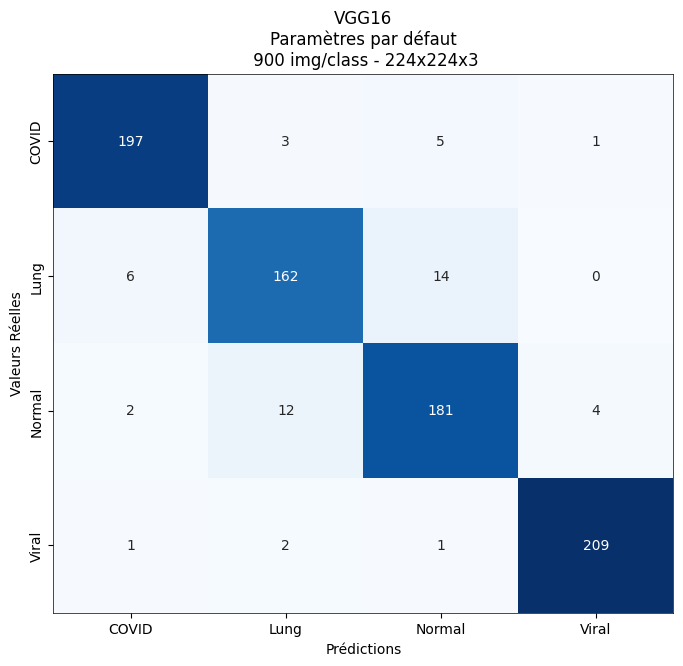

In [10]:
#affichage de la matric de confusion
plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=['COVID', 'Lung', 'Normal', 'Viral'],
            yticklabels=['COVID', 'Lung', 'Normal', 'Viral'])
plt.title('VGG16\nParamètres par défaut\n 900 img/class - 224x224x3')
ax = plt.gca()
for _, spine in ax.spines.items():
    spine.set_visible(True)
    spine.set_color('black')
    spine.set_linewidth(0.5)
plt.xlabel('Prédictions')
plt.ylabel('Valeurs Réelles')
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


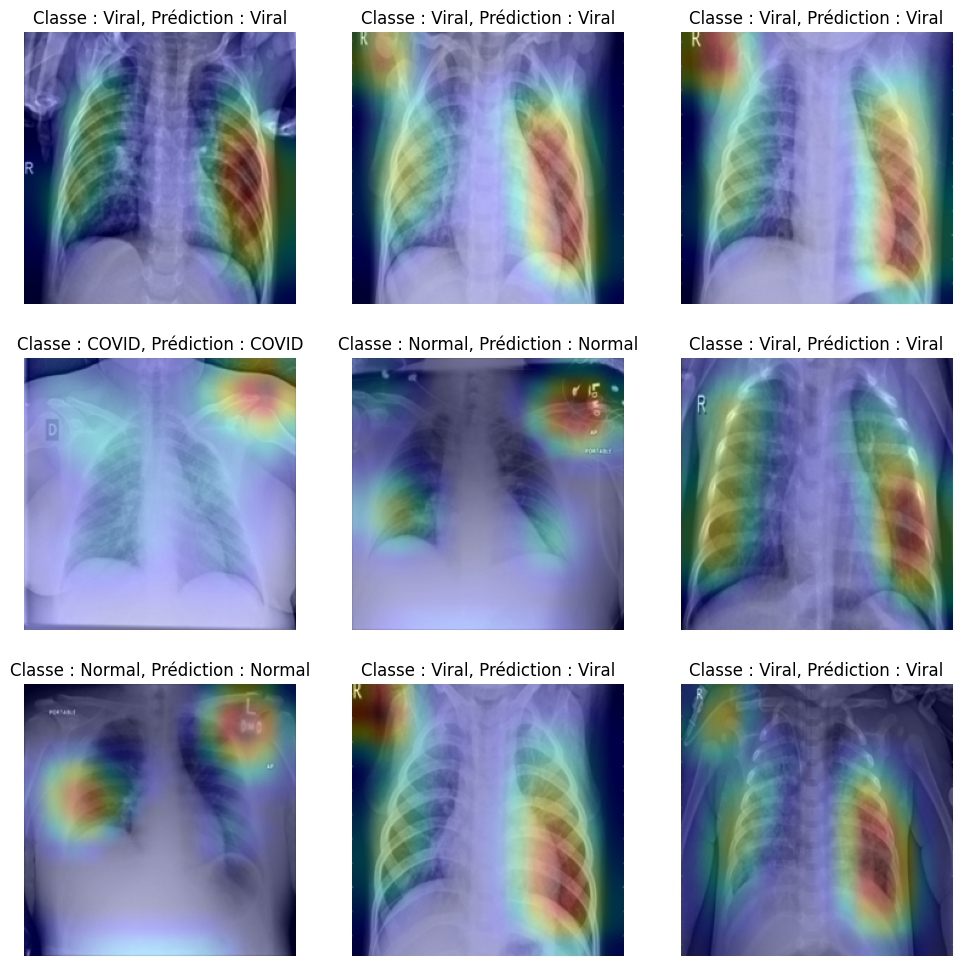

In [18]:
#affichage aléatoire de 9 prédictions avec leur Grad-CAM associées
from grad_cam import make_gradcam_heatmap, save_and_display_gradcam
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.layers import Conv2D
     
classes = ['COVID', 'Lung', 'Normal', 'Viral']

y_test_classes = np.argmax(y_test, axis=1)
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Désactivation de l'activation softmax de la dernière couche
new_model.layers[-1].activation = None

# Identification du nom de la dernière couche Conv2D
last_conv_layer_name = None
for layer in reversed(new_model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

# Préparation de la figure pour afficher 5 images
plt.figure(figsize=(12, 12))  # Largeur, hauteur en pouces
for i in range(9):
    R = random.randint(0, len(X_test) - 1)
    base_img = X_test[R]
    heatm_img = np.expand_dims(base_img, axis=0)
    img_cam = np.uint8(base_img * 255)  # Conversion de l'image pour affichage

    # Prédiction sans la couche softmax activée
    preds = new_model.predict(heatm_img)
    heatmap = make_gradcam_heatmap(heatm_img, new_model, last_conv_layer_name)
    grad_img = save_and_display_gradcam(img_cam, heatmap)

    # Vérification de la vraie classe et de la prédiction
    vraie = classes[y_test_classes[R]]
    prediction = classes[y_pred_classes[R]]

    # Affichage dans un sous-graphique
    plt.subplot(3, 3, i + 1)  # 1 ligne, 5 colonnes, ième position
    plt.imshow(grad_img)
    plt.title(f"Classe : {vraie}, Prédiction : {prediction}")
    plt.axis('off')  # Désactivation des axes pour une meilleure visibilité

plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


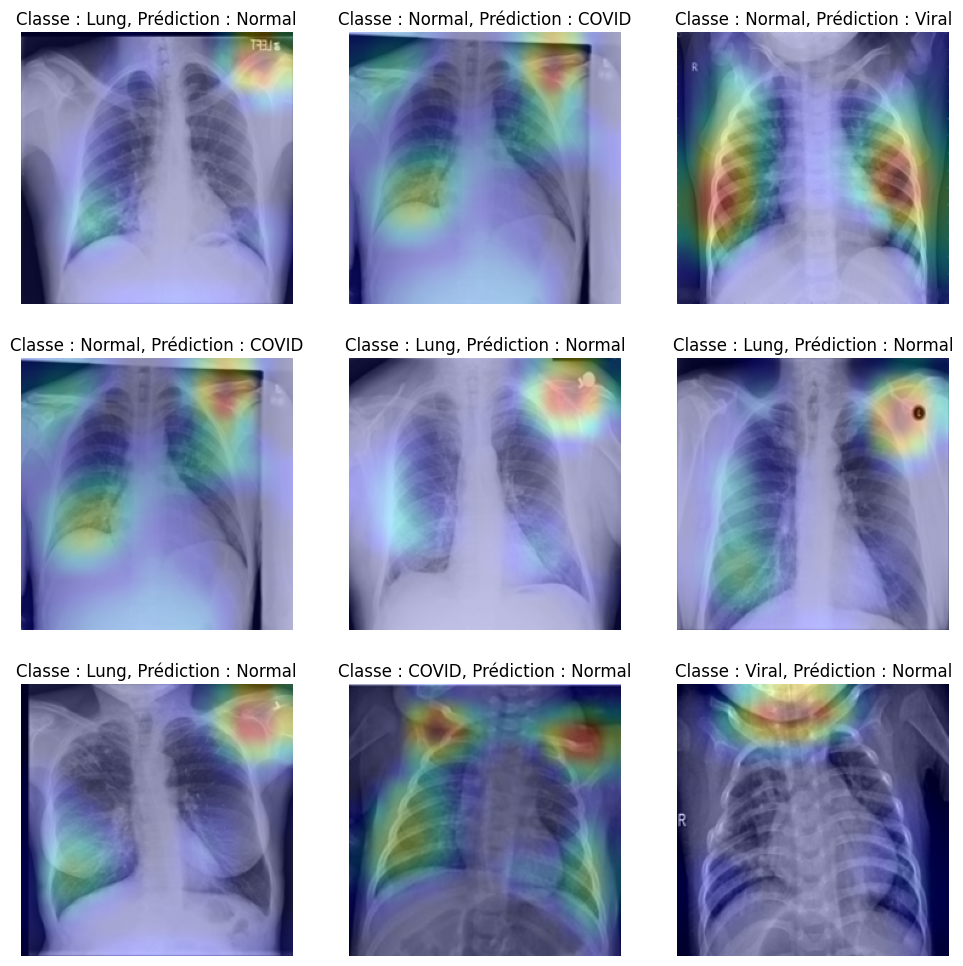

In [12]:
#affichage aléatoire de 9 prédictions fausses avec leur Grad-CAM associées
from grad_cam import make_gradcam_heatmap, save_and_display_gradcam
import matplotlib.pyplot as plt
import random
import numpy as np
from keras.layers import Conv2D

classes = ['COVID', 'Lung', 'Normal', 'Viral']

y_test_classes = np.argmax(y_test, axis=1)
y_pred = new_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

indices_diff = np.where(y_test_classes != y_pred_classes)[0]

# Désactivation de l'activation softmax de la dernière couche
new_model.layers[-1].activation = None

# Identification du nom de la dernière couche Conv2D
last_conv_layer_name = None
for layer in reversed(new_model.layers):
    if isinstance(layer, Conv2D):
        last_conv_layer_name = layer.name
        break

# Préparation de la figure pour afficher 5 images
plt.figure(figsize=(12, 12))  # Largeur, hauteur en pouces
for i in range(9):
    R = random.choice(indices_diff)
    base_img = X_test[R]
    heatm_img = np.expand_dims(base_img, axis=0)
    img_cam = np.uint8(base_img * 255)  # Conversion de l'image pour affichage

    # Prédiction sans la couche softmax activée
    preds = new_model.predict(heatm_img)
    heatmap = make_gradcam_heatmap(heatm_img, new_model, last_conv_layer_name)
    grad_img = save_and_display_gradcam(img_cam, heatmap)

    # Vérification de la vraie classe et de la prédiction
    vraie = classes[y_test_classes[R]]
    prediction = classes[y_pred_classes[R]]

    # Affichage dans un sous-graphique
    plt.subplot(3, 3, i + 1)  # 1 ligne, 5 colonnes, ième position
    plt.imshow(grad_img)
    plt.title(f"Classe : {vraie}, Prédiction : {prediction}")
    plt.axis('off')  # Désactivation des axes pour une meilleure visibilité

plt.show()